# Demo 1 Pipeline with preprocessor and xgb model

## 0.Create Raw Data
A made up dataframe with 4 features and 10 samples. The definition of leaf output and feature importance are illustrated.

In [1]:
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
import math
import os
import xgboost as xgb
from xgboost import plot_tree,to_graphviz
from scipy.special import expit, logit
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV


df=pd.DataFrame({'y':[0,0,0,0,0,1,1,1,0,1],
                 'x1':['H','H','H','H','H','H','L','L',np.nan,'H'],
                 'x2':[2.8,3,2,2.6,3,3,2.7,4.5,1.3,4.2],
                 'x3':[np.nan,2,4.2,2.6,3,2.7,6,2,2,4]
                })
X=df[['x1','x2','x3']].replace(r'^\s+$', np.nan, regex=True)
num_cols=['x2','x3']
cat_cols=['x1']
y=df['y']
print(X)

    x1   x2   x3
0    H  2.8  NaN
1    H  3.0  2.0
2    H  2.0  4.2
3    H  2.6  2.6
4    H  3.0  3.0
5    H  3.0  2.7
6    L  2.7  6.0
7    L  4.5  2.0
8  NaN  1.3  2.0
9    H  4.2  4.0


## 1.Preprocessor and XGB Pipeline
### Data preprocessor pipeline
Passes through numeric features and processes categorical features with transformer, imputing missings and one-hot encoding.

#### Categorical feature processor

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
imputer = SimpleImputer(strategy='constant', fill_value='NA')
cat_transformer = Pipeline(steps=[("imputer",SimpleImputer(strategy='constant', fill_value='NA')),
                                       ("enc",OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

In [3]:
X[['x1']].iloc[:4]

,x1
0,H
1,H
2,H
3,H


- Demo use 

In [4]:
X_imputed = imputer.fit_transform(X[['x1']].iloc[3:7])
X_encoded=enc.fit_transform(X_imputed)

print(f"Categories: {enc.categories_}")
print(f"One-hot encoded")
print(X_encoded)
print('One-hot decoded')
print(enc.inverse_transform(X_encoded))

Categories: [array(['H', 'L'], dtype=object)]
One-hot encoded
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
One-hot decoded
[['H']
 ['H']
 ['H']
 ['L']]


### Data preprocessor

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as col_selector

preprocessor = ColumnTransformer([("numerical", "passthrough", col_selector(dtype_exclude=object)), 
                                  ("categorical", cat_transformer,col_selector(dtype_include=object))])

### Preprocessor and XGB Pipeline

In [6]:
param = { 'objective':'binary:logistic','base_score':0.5,'n_estimators':2,'eta':0.5,
         'max_depth':2, 'gamma':0.6,'min_child_weight':0,'lambda':1}
model=xgb.XGBClassifier(n_jobs=-1,**param)
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      ("model",model)])

## 2.Fit Model and Output Model

### Fit model

In [7]:
xgb_model.fit(X,y)
proba=xgb_model.predict_proba(X)
print(proba)
preprocessor=xgb_model.named_steps["preprocessor"]
enc=preprocessor.named_transformers_['categorical'].named_steps['enc']

[[0.7011472  0.29885283]
 [0.5962753  0.4037247 ]
 [0.7011472  0.29885283]
 [0.7011472  0.29885283]
 [0.5962753  0.4037247 ]
 [0.5962753  0.4037247 ]
 [0.37965727 0.62034273]
 [0.34879583 0.65120417]
 [0.7011472  0.29885283]
 [0.40181476 0.59818524]]


### Extract feature name info
Generate multi-index of one-hot encoded feature names info for feature importance, create xgb feature mapping file "xgb_fmap.txt" for plotting trees.

In [8]:
#enc.get_feature_names(input_features=cat_cols)
tuples_cat=[(col,f"{col}_{col_ohe}") for col,col_ohes in zip(cat_cols,enc.categories_) for col_ohe in col_ohes ]
tuples_num=list(zip(num_cols,num_cols))
tuples=tuples_num+tuples_cat
print(tuples)
idx=pd.MultiIndex.from_tuples(tuples,names=('feature', 'feature_encoded'))

outfile = open('xgb_fmap.txt', 'w')
for i,feat in enumerate(idx.get_level_values(1)):
    outfile.write('{0}\t{1}\tq\n'.format(i, feat))
outfile.close()

[('x2', 'x2'), ('x3', 'x3'), ('x1', 'x1_H'), ('x1', 'x1_L'), ('x1', 'x1_NA')]


In [9]:
categories=preprocessor.named_transformers_['categorical'].named_steps['enc'].categories_
cat_ohe_name=[f"{col}_{ohe}" for col,ohes in zip(cat_cols,categories) for ohe in ohes ]
f_map={"f"+str(i):name for i,name in enumerate(num_cols+cat_ohe_name)}
print(f_map)

for score_type in ['weight','gain','cover','total_gain','total_cover']:
    scores=model.get_booster().get_score(importance_type=score_type)
    print(score_type+str({f_map[f]:s for (f,s) in scores.items()}))

{'f0': 'x2', 'f1': 'x3', 'f2': 'x1_H', 'f3': 'x1_L', 'f4': 'x1_NA'}
weight{'x2': 2.0, 'x3': 1.0, 'x1_L': 1.0}
gain{'x2': 1.2009048461914062, 'x3': 1.139393925666809, 'x1_L': 1.0318323373794556}
cover{'x2': 2.202906608581543, 'x3': 2.0, 'x1_L': 2.396512269973755}
total_gain{'x2': 2.4018096923828125, 'x3': 1.139393925666809, 'x1_L': 1.0318323373794556}
total_cover{'x2': 4.405813217163086, 'x3': 2.0, 'x1_L': 2.396512269973755}


In [10]:
cat=[f"{col}_{col_ohe}" for col,col_ohes in zip(cat_cols,enc.categories_) for col_ohe in col_ohes ]
cols=num_cols+cat
score=model.get_booster().get_score(importance_type='weight')
print(cols)
print(score)
{f_map[f]:s for (f,s) in scores.items()}

['x2', 'x3', 'x1_H', 'x1_L', 'x1_NA']
{'f0': 2.0, 'f1': 1.0, 'f3': 1.0}


{'x2': 4.405813217163086, 'x3': 2.0, 'x1_L': 2.396512269973755}

### Plot trees

In [11]:
model=xgb_model.named_steps["model"]

booster=model.get_booster()
trees=booster.get_dump()
trees=model.get_booster().get_dump()
for tree in trees:
    print(tree)
n=len(trees)  #get number of trees
#plot trees
node_params = {'shape': 'box', ## make the nodes fancy
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

0:[f0<4.19999981] yes=1,no=2,missing=2
	1:[f1<6] yes=3,no=4,missing=3
		3:leaf=-0.454545468
		4:leaf=0.200000003
	2:leaf=0.333333343

0:[f3<1] yes=1,no=2,missing=2
	1:[f0<3] yes=3,no=4,missing=4
		3:leaf=-0.398221195
		4:leaf=0.0645761117
	2:leaf=0.291003078



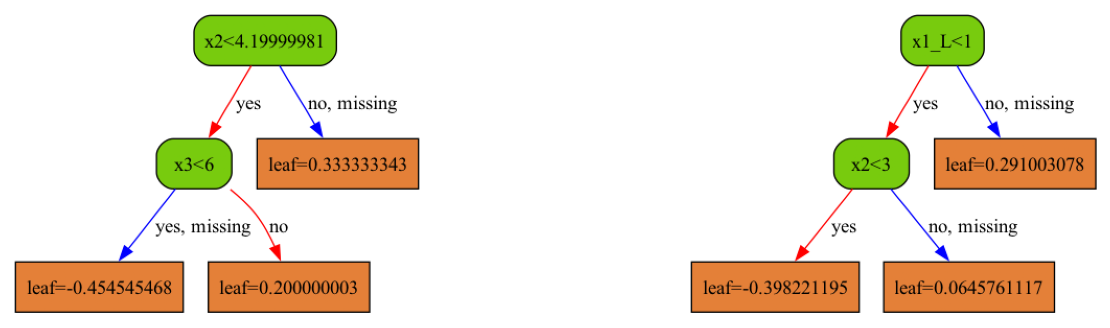

In [12]:
#the following dictionary tree plot parameters
node_params = {'shape': 'box', ## make the nodes fancy
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

fix,axs=plt.subplots(1,n,figsize=(16,4))
for i in range(n):
    xgb.plot_tree(model, num_trees=i, ax = axs[i],
                  condition_node_params=node_params,
                  leaf_node_params=leaf_params,
                 fmap="xgb_fmap.txt")

### Extract feature importance

In [13]:
score_raw_df=pd.DataFrame([f"f{ind}" for ind in range(len(idx))],index=idx,columns=['xgb_name'])

for score_type in ['weight','gain','cover','total_gain','total_cover']:
    score=model.get_booster().get_score(importance_type=score_type)
    score_raw_df[score_type]=score_raw_df['xgb_name'].map(score)
print(score_raw_df)
score=score_raw_df.groupby(level=[0]).agg(
    {'weight':sum,'gain':np.mean,'cover':np.mean,'total_gain':sum,'total_cover':sum})    

                        xgb_name  weight      gain     cover  total_gain  \
feature feature_encoded                                                    
x2      x2                    f0     2.0  1.200905  2.202907    2.401810   
x3      x3                    f1     1.0  1.139394  2.000000    1.139394   
x1      x1_H                  f2     NaN       NaN       NaN         NaN   
        x1_L                  f3     1.0  1.031832  2.396512    1.031832   
        x1_NA                 f4     NaN       NaN       NaN         NaN   

                         total_cover  
feature feature_encoded               
x2      x2                  4.405813  
x3      x3                  2.000000  
x1      x1_H                     NaN  
        x1_L                2.396512  
        x1_NA                    NaN  


## Hyperparamter Tuning

In [14]:
N=1000
X_full=pd.concat([X]*N)
y_full=pd.concat([y]*N)
gs = GridSearchCV(xgb_model, {"model__max_depth": [1,2,3], 
                             "model__n_estimators": [2,3,4,5]}, 
                  n_jobs=-1, cv=5,scoring='roc_auc')

gs.fit(X_full, y_full)
print(gs.best_params_)
print(gs.best_score_)
best_model = gs.best_estimator_
proba = best_model.predict_proba(X_full)
print(proba[:4,1])

{'model__max_depth': 2, 'model__n_estimators': 4}
1.0
[0.09699517 0.17778848 0.12264672 0.1222282 ]
